In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
from PIL import Image

2025-10-26 17:03:45.454367: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 17:03:45.455898: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 17:03:45.481814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 17:03:45.481853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 17:03:45.482915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data_dir = r"/home/faisal/code/MrZeroX1/Aivine/raw_data/Plant_type_classification/Plant_type_classification"


In [3]:
img_size = (128, 128)

In [4]:
# --- Image Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

In [ ]:
# --- Load Images + Augmentation ---
X_aug, y_aug = [], []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg','.jpeg','.png','.webp')):
            img_path = os.path.join(folder_path, file)
            try:
                try:
                    img = load_img(img_path, target_size=img_size)
                except:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                x = img_to_array(img)
                x = preprocess_input(x)  # MobileNetV2 preprocessing
                x = x.reshape((1, *x.shape))

                # Original image
                X_aug.append(x.flatten())
                y_aug.append(folder)

                # Generate 5 augmented images per original
                for i, batch in enumerate(datagen.flow(x, batch_size=1)):
                    X_aug.append(batch.flatten())
                    y_aug.append(folder)
                    if i >= 4:  # 5 augmentations
                        break
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

X_aug = np.array(X_aug, dtype='float32')
y_aug = np.array(y_aug)

print(f"✅ Total images after augmentation: {len(X_aug)}")


/home/faisal/.pyenv/versions/3.10.14/envs/aivine_env/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ Total images after augmentation: 2370


In [ ]:
# --- Encode Labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y_aug)

# --- Split Dataset ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_aug, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- MobileNetV2 Feature Extractor ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')
def extract_features(X):
    X_reshaped = X.reshape((-1, *img_size, 3))
    return base_model.predict(X_reshaped, verbose=0)

X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)


# --- Models and Hyperparameters ---
models_params = {
    "SVM": (
        SVC(),
        {'C':[1,5,10], 'gamma':[0.001,0.01,'scale'], 'kernel':['rbf']}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {'n_estimators':[100,200], 'max_depth':[10,15,None]}
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=2000),
        {'C':[0.1,1,10]}
    )
}

# --- Train & GridSearch ---
best_results = []
for name, (model, params) in models_params.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_features, y_train)
    best_model = grid.best_estimator_
    print(f"Best Params: {grid.best_params_}")

    y_pred = best_model.predict(X_val_features)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_val, y_pred, target_names=le.classes_))

    best_results.append((name, acc, best_model))

9406464/9406464 [==============================] - 12s 1us/step

Training SVM...
Best Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVM Accuracy: 97.89%
               precision    recall  f1-score   support

Chrysanthemum       0.98      0.99      0.98        82
     Hibiscus       0.98      0.97      0.97        89
  Money_Plant       0.98      0.99      0.98        95
         Rose       0.98      0.96      0.97       116
     Turmeric       0.98      1.00      0.99        92

     accuracy                           0.98       474
    macro avg       0.98      0.98      0.98       474
 weighted avg       0.98      0.98      0.98       474


Training RandomForest...
Best Params: {'max_depth': None, 'n_estimators': 200}
RandomForest Accuracy: 88.19%
               precision    recall  f1-score   support

Chrysanthemum       0.91      0.87      0.89        82
     Hibiscus       0.94      0.74      0.83        89
  Money_Plant       0.92      0.91      0.91        95
         Rose

In [7]:
# --- Summary ---
best_overall = max(best_results, key=lambda x: x[1])
print(f"\nBest Model: {best_overall[0]} | Accuracy: {best_overall[1]*100:.2f}%")


Best Model: SVM | Accuracy: 97.89%


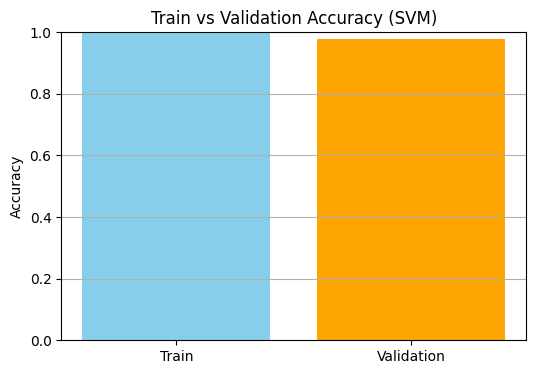

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model = best_overall[2]

y_train_pred = model.predict(X_train_features)
train_accuracy = accuracy_score(y_train, y_train_pred)

val_accuracy = best_overall[1]

plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation'], [train_accuracy, val_accuracy], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy (SVM)')
plt.grid(axis='y')
plt.show()


In [ ]:
import joblib

joblib.dump(best_overall[2], "best_model_svm.pkl")
print("Model saved as best_model_svm.pkl")


Model saved as best_model_svm.pkl


In [18]:
joblib.dump(le, "label_encoder.pkl")
print("LabelEncoder saved as label_encoder.pkl")

LabelEncoder saved as label_encoder.pkl


In [ ]:
# loaded_model = joblib.load("best_model_svm.pkl")
# predictions = loaded_model.predict(X_new_features)

In [31]:
best_model = joblib.load("best_model_svm.pkl")
le = joblib.load("label_encoder.pkl")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')

def predict_plant(img_path):
    img = load_img(img_path, target_size=(128,128))
    x = img_to_array(img)
    x = preprocess_input(x)
    x = x.reshape((1, 128, 128, 3))
    features = base_model.predict(x, verbose=0)
    pred_idx = best_model.predict(features)[0]
    pred_class = le.inverse_transform([pred_idx])[0]
    return pred_class

print("Predicted class:", predict_plant("test_image/test2.jpg"))


Predicted class: Rose


In [ ]:
"""

from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
import joblib

best_model = joblib.load("best_model_svm.pkl")
le = joblib.load("label_encoder.pkl")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')

def predict_plant_from_bytes(img_bytes):

    img = Image.open(img_bytes).convert("RGB").resize((128,128))

    x = img_to_array(img)
    x = preprocess_input(x)
    x = x.reshape((1, *x.shape))

    features = base_model.predict(x, verbose=0)

    pred_idx = best_model.predict(features)[0]
    pred_class = le.inverse_transform([pred_idx])[0]
    return pred_class



"""